# Porting PyTorch to ONNX to OpenVINO

## Packages

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import onnx
import onnxruntime
from openvino.inference_engine import IENetwork, IEPlugin
from matplotlib import pyplot as plt

This notebook is checked with PyTorch 1.0.1 and torchvision 0.2.0

In [2]:
! pip list | grep torch

torch              1.0.1  
torchvision        0.2.0  


ONNX 1.5.0 and ONNXruntime 0.4.0 is suggested

In [3]:
! pip list | grep onnx

onnx               1.5.0  
onnxruntime        0.4.0  


## Instanciate a pretrained PyTorch model

In [4]:
# model instance
model = models.inception_v3(pretrained=True)

# apply cuda
if torch.cuda.is_available():
    model = model.cuda()

# evaluation mode
model = model.eval()

## Input transformation for PyTorch

In [5]:
target_size = 299 # 299 for inception_v3, and 224 for the rest
trans = transforms.Compose([
    transforms.Resize(int(target_size/224*256)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Introduce the label map from ImageNet

In [6]:
from imagenet_labels import labelmap
print(list(labelmap.values())[:10])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus']


## Read in the input image

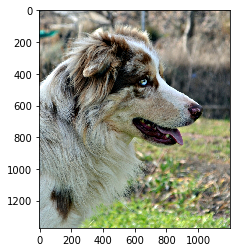

In [7]:
image = Image.open('dog-bcollie.jpg')
plt.imshow(image)

## PyTorch inference

In [8]:
# apply transformation
image_tensor = trans(image)
# extend batch dimension
image_tensor = image_tensor.unsqueeze(dim=0)
# apply cuda
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()

logits = model(image_tensor)

In [9]:
k = 10
values, indices = torch.topk(logits, k)
for i in range(k):
    print(values[0][i].item(), labelmap[indices[0][i].item()])

9.824918746948242 collie
8.656900405883789 Border collie
5.762895107269287 Shetland sheepdog, Shetland sheep dog, Shetland
5.18283748626709 Cardigan, Cardigan Welsh corgi
4.905889987945557 Eskimo dog, husky
4.219264030456543 Great Pyrenees
4.133235454559326 Pembroke, Pembroke Welsh corgi
3.9328904151916504 Australian terrier
3.7350897789001465 Siberian husky
3.5356228351593018 kelpie


## Porting to ONNX
Save the processed image tensor as numpy array

In [10]:
print('image tensor shape = ', image_tensor.shape)
print('top left patch (green channel) = ', image_tensor[0,1,:2,:2])
np.savez('test_input.npz', image_tensor.cpu())

# test if it can be loaded correctly
image_file = np.load('test_input.npz')
image_np = image_file['arr_0']
image_file.close()
print('image numpy array shape = ', image_np.shape)
print('top left patch (green channel) = ', image_np[0,1,:2,:2])

image tensor shape =  torch.Size([1, 3, 299, 299])
top left patch (green channel) =  tensor([[0.6254, 0.8354],
        [0.6604, 0.8179]])
image numpy array shape =  (1, 3, 299, 299)
top left patch (green channel) =  [[0.62535024 0.83543426]
 [0.6603642  0.81792724]]


Convert the model to ONNX

In [11]:
# export the model
onnx_file = 'model.onnx'
torch.onnx._export(model, image_tensor, onnx_file, export_params=True, verbose=True)
# print model information
model_onnx = onnx.load(onnx_file)
onnx.checker.check_model(model_onnx) # will print nothing if nothing wrong

graph(%0 : Float(1, 3, 299, 299)
      %1 : Float(32, 3, 3, 3)
      %2 : Float(32)
      %3 : Float(32)
      %4 : Float(32)
      %5 : Float(32)
      %6 : Long()
      %7 : Float(32, 32, 3, 3)
      %8 : Float(32)
      %9 : Float(32)
      %10 : Float(32)
      %11 : Float(32)
      %12 : Long()
      %13 : Float(64, 32, 3, 3)
      %14 : Float(64)
      %15 : Float(64)
      %16 : Float(64)
      %17 : Float(64)
      %18 : Long()
      %19 : Float(80, 64, 1, 1)
      %20 : Float(80)
      %21 : Float(80)
      %22 : Float(80)
      %23 : Float(80)
      %24 : Long()
      %25 : Float(192, 80, 3, 3)
      %26 : Float(192)
      %27 : Float(192)
      %28 : Float(192)
      %29 : Float(192)
      %30 : Long()
      %31 : Float(64, 192, 1, 1)
      %32 : Float(64)
      %33 : Float(64)
      %34 : Float(64)
      %35 : Float(64)
      %36 : Long()
      %37 : Float(48, 192, 1, 1)
      %38 : Float(48)
      %39 : Float(48)
      %40 : Float(48)
      %41 : Float(48)
      %42 : Long

Test running on ONNX model

In [12]:
onnx_session = onnxruntime.InferenceSession(onnx_file)
input_blob = onnx_session.get_inputs()[0].name
output_blob = onnx_session.get_outputs()[0].name
res = onnx_session.run([output_blob], {input_blob: image_np})
logits = res[0].squeeze()

In [13]:
k = 10
indices = logits.argsort()[::-1][:k]
for i in indices:
    print(logits[i], labelmap[i])

9.439106 collie
8.824579 Border collie
5.332166 Cardigan, Cardigan Welsh corgi
5.2635207 Eskimo dog, husky
4.816754 Shetland sheepdog, Shetland sheep dog, Shetland
4.089167 Australian terrier
3.8295376 Pembroke, Pembroke Welsh corgi
3.8219712 Siberian husky
3.8121974 Great Pyrenees
3.5604472 kelpie


## Convert to OpenVINO IR

Making sure the OpenVINO path is set to `$PYTHONPATH`

In [14]:
! echo $PYTHONPATH | grep openvino

/opt/intel//openvino_2019.1.090/python/python3.7:/opt/intel//openvino_2019.1.090/deployment_tools/model_optimizer:


Run model converter

In [15]:
! python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --input_model model.onnx

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/Users/tzaumiaan/workspace/openvino_porting/model.onnx
	- Path for generated IR: 	/Users/tzaumiaan/workspace/openvino_porting/.
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2019.1.0-341-gc9b66a2
[ WARNING ]  
Detected not satisfied dependencies:
	test-generator: installed: 0.1.2, required: 0.1.1

Please install required versions of components or use install_prerequisit

## Run OpenVINO inference

Now we have `*.xml` and `*.bin` files for inferencing

In [16]:
def load_openvino_model(device, model_xml, model_bin):
    plugin = IEPlugin(device=device, plugin_dirs=None)
    net = IENetwork(model=model_xml, weights=model_bin)
    supported_layers = plugin.get_supported_layers(net)
    not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
    if len(not_supported_layers) != 0:
        print("Following layers are not supported by the plugin for specified device {}:\n {}".format(plugin.device, ', '.join(not_supported_layers)))
    else:
        print("All layers supported")
    exec_net = plugin.load(network=net)
    input_blob = next(iter(net.inputs))
    output_blob = next(iter(net.outputs))
    return plugin, exec_net, input_blob, output_blob

In [17]:
# load model
plugin, exec_net, input_blob, output_blob = load_openvino_model('CPU', 'model.xml', 'model.bin')

All layers supported


In [18]:
# run inference
res = exec_net.infer(inputs={input_blob: image_np})
logits = res[output_blob].squeeze()

In [19]:
k = 10
indices = logits.argsort()[::-1][:k]
for i in indices:
    print(logits[i], labelmap[i])

9.520266 collie
9.084652 Border collie
5.2057185 Cardigan, Cardigan Welsh corgi
5.1046996 Eskimo dog, husky
4.841126 Shetland sheepdog, Shetland sheep dog, Shetland
4.323918 Australian terrier
3.6155164 Pembroke, Pembroke Welsh corgi
3.5092154 Siberian husky
3.501255 kelpie
3.4103625 Great Pyrenees
